In the first exercise, we will build a basic classification model for a single object, so as to build more complex architectures in the next exercises

# Import libs

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models.resnet import ResNet18_Weights
from PIL import Image

# Data

## Download

Download the data from Kagglehub

In [2]:
import kagglehub

current_dir = os.getcwd()
os.environ['KAGGLEHUB_CACHE'] = current_dir
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print(f"Data directory: {data_dir}")

Data directory: c:\Learning\AIO\AIO24\Module7\ObjectDetection_Part1\datasets\andrewmvd\dog-and-cat-detection\versions\1


## Define Pytorch dataset

Because we only deal with single object in this exercise, we will skip all data with more than 1 objects

In [11]:
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform = None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform

        # Get all XML files in the annotations directory
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_images_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                file_name = f
                annotation_name = os.path.splitext(file_name)[0] + '.xml'
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                # Only keep images with single object
                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_images_files.append(file_name)
                else:
                    print(f"Skipping {file_name} due to multiple objects in annotation.")
        return valid_images_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            return len(root.findall('object'))
        except FileNotFoundError:
            return 0
        
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        label = None
        for obj in root.findall('object'):
            name = obj.find('name').text
            if (label is None):
                label = name
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        if label_num == -1:
            raise ValueError(f"Unknown label {label} in annotation {annotation_path}.")
        return label_num
        
    def __len__(self): 
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Get the image
        file_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, file_name)
        image = Image.open(image_path).convert('RGB')

        # Get the annotation
        annotation_name = os.path.splitext(file_name)[0] + '.xml'
        annotation_path = os.path.join(self.annotations_dir, annotation_name)
        label = self.parse_annotation(annotation_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
annotation_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(annotations_dir=annotation_dir, image_dir=image_dir, transform=data_transforms)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

Skipping Cats_Test736.png due to multiple objects in annotation.


## Create Dataloader

In [15]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Modeling

In [16]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Assuming binary classification (dog vs cat)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

In [17]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}, "
          f"Validation Accuracy: {100 * correct / total:.2f}%")
    

Epoch [1/15], Train Loss: 0.1895, Validation Loss: 0.7827, Validation Accuracy: 89.55%
Epoch [2/15], Train Loss: 0.0570, Validation Loss: 0.1432, Validation Accuracy: 92.54%
Epoch [3/15], Train Loss: 0.0627, Validation Loss: 0.4774, Validation Accuracy: 85.62%
Epoch [4/15], Train Loss: 0.1373, Validation Loss: 0.4382, Validation Accuracy: 88.20%
Epoch [5/15], Train Loss: 0.1979, Validation Loss: 0.3129, Validation Accuracy: 86.57%
Epoch [6/15], Train Loss: 0.2578, Validation Loss: 0.2151, Validation Accuracy: 93.22%
Epoch [7/15], Train Loss: 0.0828, Validation Loss: 0.0990, Validation Accuracy: 97.15%
Epoch [8/15], Train Loss: 0.0203, Validation Loss: 0.0975, Validation Accuracy: 96.47%
Epoch [9/15], Train Loss: 0.0169, Validation Loss: 0.1401, Validation Accuracy: 95.12%
Epoch [10/15], Train Loss: 0.1204, Validation Loss: 0.3920, Validation Accuracy: 89.69%
Epoch [11/15], Train Loss: 0.0413, Validation Loss: 0.1078, Validation Accuracy: 96.34%
Epoch [12/15], Train Loss: 0.0112, Valida

## Inference

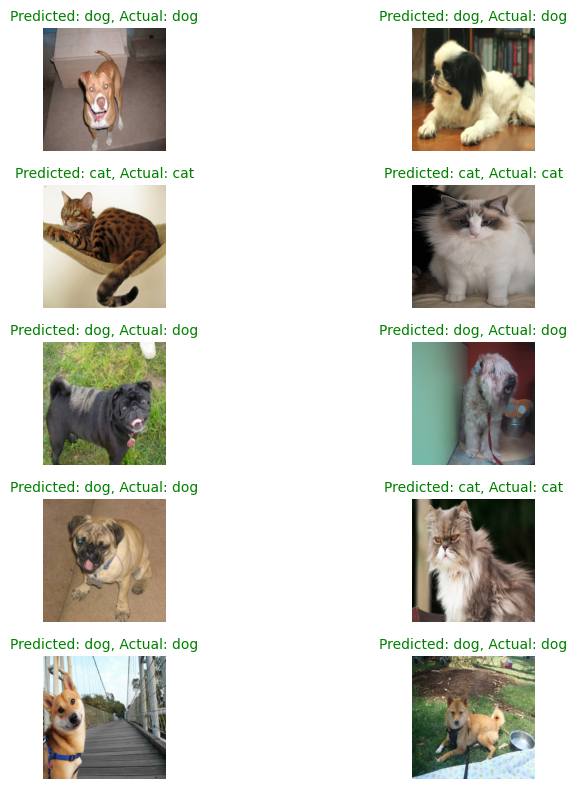

In [21]:
def visualize_predictions(model, dataloader, num_images=6):
    model.eval()
    images_so_far = 0
    class_names = ["cat", "dog"]
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(
                    f"Predicted: {class_names[preds[j]]}, Actual: {class_names[labels[j]]}",
                    fontdict={
                        "fontsize": 10,
                        "color": "green" if preds[j] == labels[j] else "red",
                    },
                )
                # Denormalize and display the image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    return


visualize_predictions(model, val_loader, num_images=10)
plt.show()

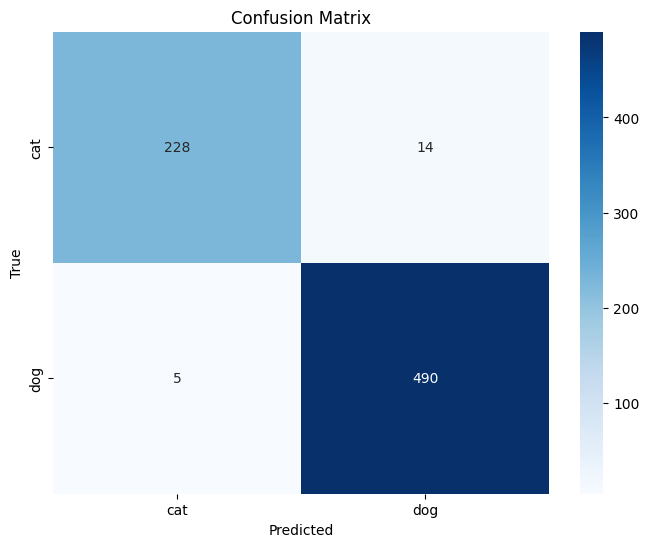

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, val_loader)